In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import optuna
from joblib import dump

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, make_scorer, recall_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [8]:
df_0 = pd.read_csv('../data/clusters/cluster_0.csv')
df_1 = pd.read_csv('../data/clusters/cluster_1.csv')
df_2 = pd.read_csv('../data/clusters/cluster_2.csv')
df_3 = pd.read_csv('../data/clusters/cluster_3.csv')
df_4 = pd.read_csv('../data/clusters/cluster_4.csv')

df_all = pd.concat([df_0, df_1, df_2, df_3, df_4], ignore_index = True).sample(frac = 1)
df_all.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,cluster
18344,0.51,3,8,3,63.2,56.0,1722,5.04,5.08,3.20,1
22645,0.35,5,5,5,61.8,55.0,1116,4.56,4.54,2.81,1
42915,2.02,3,8,3,62.3,56.0,17263,7.99,8.06,5.00,4
12968,0.53,5,5,5,62.1,54.0,1893,5.18,5.22,3.23,1
10468,0.31,4,4,4,60.5,58.0,707,4.40,4.43,2.67,0
29487,0.57,5,8,5,61.3,56.0,2546,5.35,5.42,3.30,2
35788,1.18,4,3,4,62.6,59.0,5477,6.73,6.71,4.21,3
16834,0.72,1,5,1,66.4,57.0,2396,5.60,5.51,3.69,1
22222,0.57,4,7,4,61.2,57.0,1414,5.35,5.31,3.26,1
40139,1.50,1,4,1,65.2,58.0,10206,7.12,7.06,4.62,3


In [9]:
data = df_all.drop(columns = ['price'], axis = 1).copy()

In [10]:
X = data.drop(columns = ['cluster'], axis = 1)
y = data['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
clusters_scaler = StandardScaler()

X_train = clusters_scaler.fit_transform(X_train)
X_test = clusters_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = X.columns.to_list())
X_test = pd.DataFrame(X_test, columns = X.columns.to_list())

In [53]:
dump(clusters_scaler, '../models/clusters/clusters_scaler.joblib')

['../models/clusters/clusters_scaler.joblib']

# Classification

In [21]:
#Defining model hyperparameters' optimization procedure for Random Forest

def forest_tuning(X, y, n_trials) :
    
    def objective(trial):
    
        #Defining the search space for hyperparameters
        
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 2, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

        #Creating a Random Forest classifier with the suggested hyperparameters
        
        rf = RandomForestClassifier(
             n_estimators = n_estimators,
             max_depth = max_depth,
             min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf,
             max_features = max_features,
             criterion = criterion,
             random_state = 42
        )

        #Calculating recall using cross-validation
        
        recalls = cross_val_score(rf, X, y, cv = 3, n_jobs = -1, scoring = make_scorer(recall_score, average = 'weighted')) # multiclass classification
        mean_recall = recalls.mean()

        return mean_recall
    
    #Creating an Optuna study and run the optimization process

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction = "maximize", sampler = sampler)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)
    
    best_params = study.best_params
    best_recall = study.best_value
    
    return best_params, best_recall

In [22]:
best_params_rf, best_recall_rf = forest_tuning(X_train, y_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
#Creating a Random Forest classifier with the best hyperparameters

model_rf_tuned = RandomForestClassifier(**best_params_rf, random_state = 42)
model_rf_tuned.fit(X_train, y_train)

y_pred_rf_tuned = model_rf_tuned.predict(X_test)

recall_rf = recall_score(y_test, y_pred_rf_tuned, average = 'weighted') 
print("Test Recall with Best Hyperparameters:", recall_rf)

Test Recall with Best Hyperparameters: 0.8258308324997221


In [30]:
clf_rf_proba = model_rf_tuned.predict_proba(X_test)
auc_score = roc_auc_score(y_test, clf_rf_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.97309073575656


Confussion Matrix:


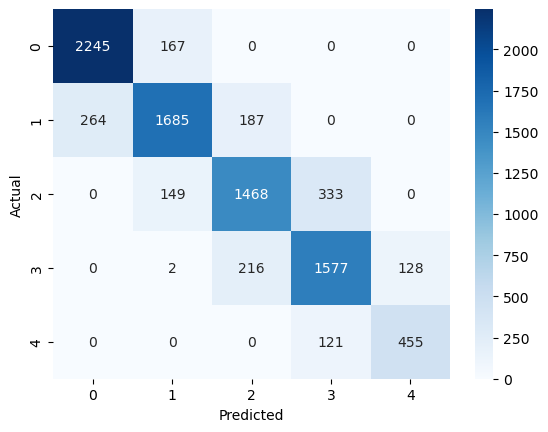

In [31]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
report = classification_report(y_test, y_pred_rf_tuned)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2412
           1       0.84      0.79      0.81      2136
           2       0.78      0.75      0.77      1950
           3       0.78      0.82      0.80      1923
           4       0.78      0.79      0.79       576

    accuracy                           0.83      8997
   macro avg       0.82      0.82      0.82      8997
weighted avg       0.83      0.83      0.83      8997



In [54]:
dump(model_rf_tuned, '../models/clusters/model_rf.joblib')

['../models/clusters/model_rf.joblib']

In [33]:
def xgboost_tuning(X, y, n_trials):
    
    def objective(trial):
        # Defining the search space for hyperparameters
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
            "objective": "multi:softmax",  # Changed for multiclass
            "num_class": len(np.unique(y)),  # Added number of classes
            "eval_metric": "mlogloss",  # Changed for multiclass
            "random_state": 42,
            "use_label_encoder": False,
            # Explicitly set to use CPU
            "tree_method": "hist",  # CPU-based method
            "device": "cpu"
        }
        # Creating an XGBoost classifier with the suggested hyperparameters
        xgb = XGBClassifier(**params)
        
        # Calculating recall using cross-validation with weighted average
        recalls = cross_val_score(xgb, X, y, cv = 3, n_jobs = -1, scoring=make_scorer(recall_score, average = 'weighted'))
        mean_recall = recalls.mean()
        return mean_recall
    
    # Creating an Optuna study and run the optimization process
    sampler = optuna.samplers.TPESampler(seed = 42)   
    study = optuna.create_study(direction = "maximize", sampler=sampler)   
    optuna.logging.set_verbosity(optuna.logging.WARNING)  
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)
    
    best_params = study.best_params
    best_recall = study.best_value
    
    return best_params, best_recall

In [34]:
best_params_xgb, best_recall_xgb = xgboost_tuning(X_train, y_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
model_xgb_tuned = XGBClassifier(**best_params_xgb, random_state = 42)
model_xgb_tuned.fit(X_train, y_train)

y_pred_xgb_tuned = model_xgb_tuned.predict(X_test)

recall_rf = recall_score(y_test, y_pred_xgb_tuned, average = 'weighted') 
print("Test Recall with Best Hyperparameters:", recall_rf)

Test Recall with Best Hyperparameters: 0.8268311659442036


In [36]:
clf_xgb_proba = model_xgb_tuned.predict_proba(X_test)
auc_score = roc_auc_score(y_test, clf_xgb_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9727117859251786


Confussion Matrix:


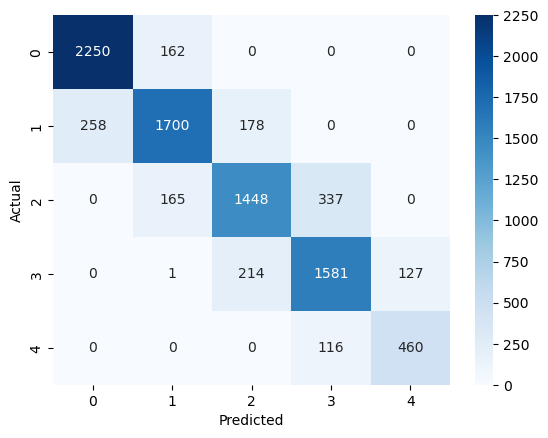

In [37]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_tuned), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [38]:
report = classification_report(y_test, y_pred_xgb_tuned)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2412
           1       0.84      0.80      0.82      2136
           2       0.79      0.74      0.76      1950
           3       0.78      0.82      0.80      1923
           4       0.78      0.80      0.79       576

    accuracy                           0.83      8997
   macro avg       0.82      0.82      0.82      8997
weighted avg       0.83      0.83      0.83      8997



In [55]:
dump(model_xgb_tuned, '../models/clusters/model_xgb.joblib')

['../models/clusters/model_xgb.joblib']

In [39]:
def lightgbm_tuning(X, y, n_trials):
   
   def objective(trial):
       params = {
           "n_estimators": trial.suggest_int("n_estimators", 100, 500),
           "max_depth": trial.suggest_int("max_depth", 3, 20),
           "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
           "num_leaves": trial.suggest_int("num_leaves", 20, 200),
           "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
           "subsample": trial.suggest_float("subsample", 0.6, 1.0),
           "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
           "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
           "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
           "random_state": 42,
           "objective": "multiclass",
           "num_class": len(np.unique(y))
       }
       
       lgbm = LGBMClassifier(**params)
       
       recalls = cross_val_score(lgbm, X, y, cv = 3, n_jobs = -1, scoring = make_scorer(recall_score, average = 'weighted'))
       mean_recall = recalls.mean()
       return mean_recall
   
   sampler = optuna.samplers.TPESampler(seed=42)   
   study = optuna.create_study(direction = "maximize", sampler=sampler)   
   optuna.logging.set_verbosity(optuna.logging.WARNING)  
   study.optimize(objective, n_trials = n_trials, n_jobs =- 1, show_progress_bar = True)
   
   best_params = study.best_params
   best_recall = study.best_value
   
   return best_params, best_recall

In [40]:
best_params_lgbm, best_recall_lgbm = lightgbm_tuning(X_train, y_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
model_lgbm_tuned = LGBMClassifier(**best_params_lgbm, random_state = 42)
model_lgbm_tuned.fit(X_train, y_train)

y_pred_lgbm_tuned = model_lgbm_tuned.predict(X_test)

recall_rf = recall_score(y_test, y_pred_lgbm_tuned, average = 'weighted') 
print("Test Recall with Best Hyperparameters:", recall_rf)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 35986, number of used features: 9
[LightGBM] [Info] Start training from score -1.311932
[LightGBM] [Info] Start training from score -1.420152
[LightGBM] [Info] Start training from score -1.531702
[LightGBM] [Info] Start training from score -1.569828
[LightGBM] [Info] Start training from score -2.736833
Test Recall with Best Hyperparameters: 0.8252750916972325


Confussion Matrix:


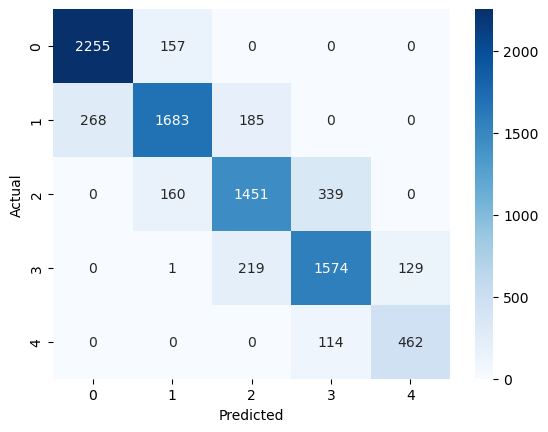

In [43]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm_tuned), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
clf_lgbm_proba = model_lgbm_tuned.predict_proba(X_test)
auc_score = roc_auc_score(y_test, clf_lgbm_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9725549215482099


In [45]:
report = classification_report(y_test, y_pred_lgbm_tuned)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2412
           1       0.84      0.79      0.81      2136
           2       0.78      0.74      0.76      1950
           3       0.78      0.82      0.80      1923
           4       0.78      0.80      0.79       576

    accuracy                           0.83      8997
   macro avg       0.82      0.82      0.82      8997
weighted avg       0.82      0.83      0.82      8997



In [56]:
dump(model_lgbm_tuned, '../models/clusters/model_lgbm.joblib')

['../models/clusters/model_lgbm.joblib']

In [46]:
def logistic_tuning(X, y, n_trials):
   
   def objective(trial):
       params = {
           "multi_class": "multinomial",
           "solver": trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "sag"]),
           "C": trial.suggest_loguniform("C", 1e-4, 10),
           "max_iter": trial.suggest_int("max_iter", 100, 1000),
           "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
       }
       
       model = LogisticRegression(**params, random_state=42)
       
       recalls = cross_val_score(model, X, y, cv=3, n_jobs=-1, 
                                 scoring=make_scorer(recall_score, average = 'weighted'))
       mean_recall = recalls.mean()
       return mean_recall
   
   sampler = optuna.samplers.TPESampler(seed=42)   
   study = optuna.create_study(direction="maximize", sampler = sampler)   
   optuna.logging.set_verbosity(optuna.logging.WARNING)  
   study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)
   
   best_params = study.best_params
   best_recall = study.best_value
   
   return best_params, best_recall

In [47]:
best_params_logreg, best_recall_logreg = logistic_tuning(X_train, y_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
model_logreg_tuned = LogisticRegression(**best_params_logreg, random_state = 42)
model_logreg_tuned.fit(X_train, y_train)

y_pred_logreg_tuned = model_logreg_tuned.predict(X_test)

recall_rf = recall_score(y_test, y_pred_logreg_tuned, average = 'weighted') 
print("Test Recall with Best Hyperparameters:", recall_rf)

Test Recall with Best Hyperparameters: 0.8016005335111704


In [49]:
clf_logreg_proba = model_logreg_tuned.predict_proba(X_test)
auc_score = roc_auc_score(y_test, clf_logreg_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9674002903737865


Confussion Matrix:


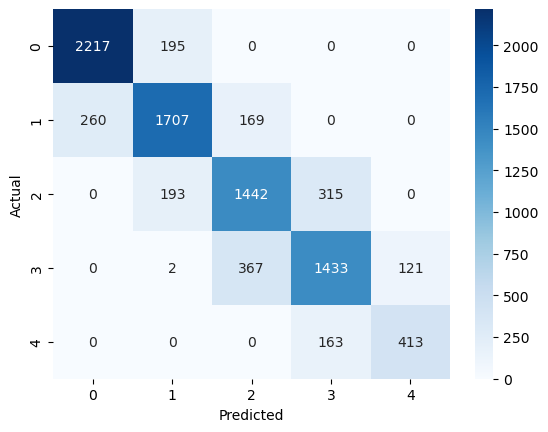

In [50]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_tuned), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
report = classification_report(y_test, y_pred_logreg_tuned)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2412
           1       0.81      0.80      0.81      2136
           2       0.73      0.74      0.73      1950
           3       0.75      0.75      0.75      1923
           4       0.77      0.72      0.74       576

    accuracy                           0.80      8997
   macro avg       0.79      0.78      0.79      8997
weighted avg       0.80      0.80      0.80      8997



In [57]:
dump(model_logreg_tuned, '../models/clusters/model_logreg.joblib')

['../models/clusters/model_logreg.joblib']

In [52]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ('model_1', model_rf_tuned),
        ('model_2', model_xgb_tuned),
        ('model_3', model_lgbm_tuned),
        ('model_4', model_logreg_tuned),
    ],
    voting = 'soft'  # 'hard' = majority vote
)

voting_clf_soft.fit(X_train, y_train)
final_predictions_soft = voting_clf_soft.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 35986, number of used features: 9
[LightGBM] [Info] Start training from score -1.311932
[LightGBM] [Info] Start training from score -1.420152
[LightGBM] [Info] Start training from score -1.531702
[LightGBM] [Info] Start training from score -1.569828
[LightGBM] [Info] Start training from score -2.736833


In [58]:
recall_rf = recall_score(y_test, final_predictions_soft, average = 'weighted') 
print("Test Recall with Best Hyperparameters:", recall_rf)

Test Recall with Best Hyperparameters: 0.8243859064132488


In [60]:
accuracy_soft = voting_clf_soft.score(X_test, y_test)
print("Soft accuracy:", accuracy_soft)

Soft accuracy: 0.8243859064132488


In [62]:
voting_soft_proba = voting_clf_soft.predict_proba(X_test)
auc_score = roc_auc_score(y_test, voting_soft_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9729488903232077


# Regression

Functions

In [262]:
# Random Forest

def randomforest_regressor_tuning(X_train, y_train, n_trials):
   
    def objective(trial):
        # Define the hyperparameter search space
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 5, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
        # Train the Random Forest Regressor
        model = RandomForestRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
            max_features = max_features,
            random_state = 42
        )
        # Cross-validation
        cv_rmse = cross_val_score(model, X_train, y_train.squeeze(), scoring = "neg_root_mean_squared_error", cv = 5)   

        # Return the mean of the RMSE across all folds
        rmse = -np.mean(cv_rmse)

        # Return RMSE for optimization
        return rmse

    # Run Optuna optimization
    sampler = optuna.samplers.TPESampler(seed = 42) 
    study = optuna.create_study(direction = "minimize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)

    # Best parameters
    rf_best_params = study.best_params
    rf_best_rmse = study.best_value
   
    return rf_best_params, rf_best_rmse

In [263]:
# XGBoost

def xgboost_regressor_tuning(X_train, y_train, n_trials):
   
    def objective(trial):
        # Define the hyperparameter search space
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        gamma = trial.suggest_float("gamma", 0, 10)
        reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
        reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
        
        # Train the XGBoost Regressor
        model = XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            learning_rate = learning_rate,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            gamma = gamma,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            random_state = 42,
            use_label_encoder = False
        )
        
        # Cross-validation
        cv_rmse = cross_val_score(model, X_train, y_train.squeeze(), scoring = "neg_root_mean_squared_error", cv = 5)   

        # Return the mean of the RMSE across all folds
        rmse = -np.mean(cv_rmse)
        
        # Return RMSE for optimization
        return rmse

    # Run Optuna optimization
    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction = "minimize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)

    # Best parameters
    xgb_best_params = study.best_params
    xgb_best_rmse = study.best_value
   
    return xgb_best_params, xgb_best_rmse

In [264]:
# LightGBM

def lightgbm_regressor_tuning(X_train, y_train, n_trials):
   
    def objective(trial):
        # Define the hyperparameter search space
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 15)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        num_leaves = trial.suggest_int("num_leaves", 20, 150)
        min_child_samples = trial.suggest_int("min_child_samples", 10, 50)
        reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
        reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
        
        # Train the LightGBM Regressor
        model = LGBMRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            learning_rate = learning_rate,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            num_leaves = num_leaves,
            min_child_samples = min_child_samples,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            random_state = 42
        )
        
        # Cross-validation
        cv_rmse = cross_val_score(model, X_train, y_train.squeeze(), scoring = "neg_root_mean_squared_error", cv = 5)   

        # Return the mean of the RMSE across all folds
        rmse = -np.mean(cv_rmse)
        
        # Return RMSE for optimization
        return rmse

    # Run Optuna optimization
    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction = "minimize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)

    # Best parameters
    lgbm_best_params = study.best_params
    lgbm_best_rmse = study.best_value
   
    return lgbm_best_params, lgbm_best_rmse

In [265]:
# CatBoost

def catboost_regressor_tuning(X_train, y_train, n_trials):
   
    def objective(trial):
        # Define the hyperparameter search space
        iterations = trial.suggest_int("iterations", 100, 1000)
        depth = trial.suggest_int("depth", 3, 12)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True)
        bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
        border_count = trial.suggest_int("border_count", 32, 255)

        # Train the CatBoost Regressor
        model = CatBoostRegressor(
            iterations = iterations,
            depth = depth,
            learning_rate = learning_rate,
            l2_leaf_reg = l2_leaf_reg,
            bagging_temperature = bagging_temperature,
            border_count = border_count,
            random_seed = 42,
            verbose = 0  # Suppress output
        )
        
        # Cross-validation
        cv_rmse = cross_val_score(model, X_train, y_train.squeeze(), scoring = "neg_root_mean_squared_error", cv = 5)   

        # Return the mean of the RMSE across all folds
        rmse = -np.mean(cv_rmse)

        # Return RMSE for optimization
        return rmse

    # Run Optuna optimization
    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction = "minimize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = 50, n_jobs = -1, show_progress_bar = True)

    # Best parameters
    cat_best_params = study.best_params
    cat_best_rmse = study.best_value
   
    return cat_best_params, cat_best_rmse

Cluster 0

In [66]:
X_0 = df_0.drop(columns = ['cluster', 'price'], axis =1)
y_0 = df_0['price']

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size = 0.2, random_state = 42)

In [408]:
scaler_0 = StandardScaler()

X_0_train = scaler_0.fit_transform(X_0_train)
X_0_test = scaler_0.transform(X_0_test)

X_0_train = pd.DataFrame(X_0_train, columns = X_0.columns.to_list())
X_0_test = pd.DataFrame(X_0_test, columns = X_0.columns.to_list())

In [409]:
dump(scaler_0, '../models/cluster 0/scaler_0.joblib')

['../models/cluster 0/scaler_0.joblib']

In [347]:
rmse_0 = []

In [266]:
rf_0_best_params, rf_0_best_rmse = randomforest_regressor_tuning(X_0_train, y_0_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [348]:
rf_0_best_model = RandomForestRegressor(**rf_0_best_params, random_state = 42)
rf_0_best_model.fit(X_0_train, y_0_train.squeeze())
rf_0_y_pred_best = rf_0_best_model.predict(X_0_test)

rf_0_best_rmse = root_mean_squared_error(y_0_test, rf_0_y_pred_best)

print('RMSE : ', rf_0_best_rmse)
print('RMSE to mean ratio : ', rf_0_best_rmse / y_0_test.mean())

rmse_0.append(rf_0_best_rmse)

RMSE :  111.15420245798845
RMSE to mean ratio :  0.15680799990606242


In [268]:
dump(rf_0_best_model, '../models/cluster 0/rf_0_best_model.joblib')

['../models/cluster 0/rf_0_best_model.joblib']

In [269]:
xgb_0_best_params, xgb_0_best_rmse = xgboost_regressor_tuning(X_0_train, y_0_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [349]:
xgb_0_best_model = XGBRegressor(**xgb_0_best_params, random_state = 42)
xgb_0_best_model.fit(X_0_train, y_0_train.squeeze())
xgb_0_y_pred_best = xgb_0_best_model.predict(X_0_test)

xgb_0_best_rmse = root_mean_squared_error(y_0_test, xgb_0_y_pred_best)

print('RMSE : ', xgb_0_best_rmse)
print('RMSE to mean ratio : ', xgb_0_best_rmse / y_0_test.mean())

rmse_0.append(xgb_0_best_rmse)

RMSE :  110.06978272609258
RMSE to mean ratio :  0.1552781820003334


In [271]:
dump(xgb_0_best_model, '../models/cluster 0/xgb_0_best_model.joblib')

['../models/cluster 0/xgb_0_best_model.joblib']

In [272]:
lgbm_0_best_params, lgbm_0_best_rmse = lightgbm_regressor_tuning(X_0_train, y_0_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [350]:
lgbm_0_best_model = LGBMRegressor(**lgbm_0_best_params, random_state = 42, verbose = -1)
lgbm_0_best_model.fit(X_0_train, y_0_train.squeeze())
lgbm_0_y_pred_best = lgbm_0_best_model.predict(X_0_test)

lgbm_0_best_rmse = root_mean_squared_error(y_0_test, lgbm_0_y_pred_best)

print('RMSE : ', lgbm_0_best_rmse)
print('RMSE to mean ratio : ', lgbm_0_best_rmse / y_0_test.mean())

rmse_0.append(lgbm_0_best_rmse)

RMSE :  110.24835384528858
RMSE to mean ratio :  0.15553009672261026


In [274]:
dump(lgbm_0_best_model, '../models/cluster 0/lgbm_0_best_model.joblib')

['../models/cluster 0/lgbm_0_best_model.joblib']

In [275]:
cat_0_best_params, cat_0_best_rmse = catboost_regressor_tuning(X_0_train, y_0_train, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

In [351]:
cat_0_best_model = CatBoostRegressor(**cat_0_best_params, random_state = 42, verbose = False)
cat_0_best_model.fit(X_0_train, y_0_train.squeeze())
cat_0_y_pred_best = cat_0_best_model.predict(X_0_test)

cat_0_best_rmse = root_mean_squared_error(y_0_test, cat_0_y_pred_best)

print('RMSE : ', cat_0_best_rmse)
print('RMSE to mean ratio : ', cat_0_best_rmse / y_0_test.mean())

rmse_0.append(cat_0_best_rmse)

RMSE :  110.0593521450569
RMSE to mean ratio :  0.15526346732006135


In [277]:
dump(cat_0_best_model, '../models/cluster 0/cat_0_best_model.joblib')

['../models/cluster 0/cat_0_best_model.joblib']

Cluster 1

In [278]:
X_1 = df_1.drop(columns = ['cluster', 'price'], axis =1)
y_1 = df_1['price']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42)

In [410]:
scaler_1 = StandardScaler()

X_1_train = scaler_1.fit_transform(X_1_train)
X_1_test = scaler_1.transform(X_1_test)

X_1_train = pd.DataFrame(X_1_train, columns = X_1.columns.to_list())
X_1_test = pd.DataFrame(X_1_test, columns = X_1.columns.to_list())

In [411]:
dump(scaler_1, '../models/cluster 1/scaler_1.joblib')

['../models/cluster 1/scaler_1.joblib']

In [354]:
rmse_1 = []

In [282]:
rf_1_best_params, rf_1_best_rmse = randomforest_regressor_tuning(X_1_train, y_1_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [355]:
rf_1_best_model = RandomForestRegressor(**rf_1_best_params, random_state = 42)
rf_1_best_model.fit(X_1_train, y_1_train.squeeze())
rf_1_y_pred_best = rf_1_best_model.predict(X_1_test)

rf_1_best_rmse = root_mean_squared_error(y_1_test, rf_1_y_pred_best)

print('RMSE : ', rf_1_best_rmse)
print('RMSE to mean ratio : ', rf_1_best_rmse / y_1_test.mean())

rmse_1.append(rf_1_best_rmse)

RMSE :  241.3033497154207
RMSE to mean ratio :  0.14569663778577413


In [284]:
dump(rf_1_best_model, '../models/cluster 1/rf_1_best_model.joblib')

['../models/cluster 1/rf_1_best_model.joblib']

In [285]:
xgb_1_best_params, xgb_1_best_rmse = xgboost_regressor_tuning(X_1_train, y_1_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [356]:
xgb_1_best_model = XGBRegressor(**xgb_1_best_params, random_state = 42)
xgb_1_best_model.fit(X_1_train, y_1_train.squeeze())
xgb_1_y_pred_best = xgb_1_best_model.predict(X_1_test)

xgb_1_best_rmse = root_mean_squared_error(y_1_test, xgb_1_y_pred_best)

print('RMSE : ', xgb_1_best_rmse)
print('RMSE to mean ratio : ', xgb_1_best_rmse / y_1_test.mean())

rmse_1.append(xgb_1_best_rmse)

RMSE :  240.49068843343528
RMSE to mean ratio :  0.14520596073307848


In [287]:
dump(xgb_1_best_model, '../models/cluster 1/xgb_1_best_model.joblib')

['../models/cluster 1/xgb_1_best_model.joblib']

In [288]:
lgbm_1_best_params, lgbm_1_best_rmse = lightgbm_regressor_tuning(X_1_train, y_1_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [357]:
lgbm_1_best_model = LGBMRegressor(**lgbm_1_best_params, random_state = 42, verbose = -1)
lgbm_1_best_model.fit(X_1_train, y_1_train.squeeze())
lgbm_1_y_pred_best = lgbm_1_best_model.predict(X_1_test)

lgbm_1_best_rmse = root_mean_squared_error(y_1_test, lgbm_1_y_pred_best)

print('RMSE : ', lgbm_1_best_rmse)
print('RMSE to mean ratio : ', lgbm_1_best_rmse / y_1_test.mean())

rmse_1.append(lgbm_1_best_rmse)

RMSE :  240.79741331136466
RMSE to mean ratio :  0.14539115825931367


In [290]:
dump(lgbm_1_best_model, '../models/cluster 1/lgbm_1_best_model.joblib')

['../models/cluster 1/lgbm_1_best_model.joblib']

In [291]:
cat_1_best_params, cat_1_best_rmse = catboost_regressor_tuning(X_1_train, y_1_train, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

In [358]:
cat_1_best_model = CatBoostRegressor(**cat_1_best_params, random_state = 42, verbose = False)
cat_1_best_model.fit(X_1_train, y_1_train.squeeze())
cat_1_y_pred_best = cat_1_best_model.predict(X_1_test)

cat_1_best_rmse = root_mean_squared_error(y_1_test, cat_1_y_pred_best)

print('RMSE : ', cat_1_best_rmse)
print('RMSE to mean ratio : ', cat_1_best_rmse / y_1_test.mean())

rmse_1.append(cat_1_best_rmse)

RMSE :  241.3167081252452
RMSE to mean ratio :  0.14570470346492817


In [293]:
dump(cat_1_best_model, '../models/cluster 1/cat_1_best_model.joblib')

['../models/cluster 1/cat_1_best_model.joblib']

Cluster 2

In [294]:
X_2 = df_2.drop(columns = ['cluster', 'price'], axis =1)
y_2 = df_2['price']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.2, random_state = 42)

In [295]:
scaler_2 = StandardScaler()

X_2_train = scaler_2.fit_transform(X_2_train)
X_2_test = scaler_2.transform(X_2_test)

X_2_train = pd.DataFrame(X_2_train, columns = X_2.columns.to_list())
X_2_test = pd.DataFrame(X_2_test, columns = X_2.columns.to_list())

In [401]:
dump(scaler_2, '../models/cluster 2/scaler_2.joblib') 

['../models/cluster 2/scaler_2.joblib']

In [360]:
rmse_2 = []

In [298]:
rf_2_best_params, rf_2_best_rmse = randomforest_regressor_tuning(X_2_train, y_2_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [361]:
rf_2_best_model = RandomForestRegressor(**rf_2_best_params, random_state = 42)
rf_2_best_model.fit(X_2_train, y_2_train.squeeze())
rf_2_y_pred_best = rf_2_best_model.predict(X_2_test)

rf_2_best_rmse = root_mean_squared_error(y_2_test, rf_2_y_pred_best)

print('RMSE : ', rf_2_best_rmse)
print('RMSE to mean ratio : ', rf_2_best_rmse / y_2_test.mean())

rmse_2.append(rf_2_best_rmse)

RMSE :  447.1744183799205
RMSE to mean ratio :  0.12057805014266836


In [300]:
dump(rf_2_best_model, '../models/cluster 2/rf_2_best_model.joblib')

['../models/cluster 2/rf_2_best_model.joblib']

In [301]:
xgb_2_best_params, xgb_2_best_rmse = xgboost_regressor_tuning(X_2_train, y_2_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [362]:
xgb_2_best_model = XGBRegressor(**xgb_2_best_params, random_state = 42)
xgb_2_best_model.fit(X_2_train, y_2_train.squeeze())
xgb_2_y_pred_best = xgb_2_best_model.predict(X_2_test)

xgb_2_best_rmse = root_mean_squared_error(y_2_test, xgb_2_y_pred_best)

print('RMSE : ', xgb_2_best_rmse)
print('RMSE to mean ratio : ', xgb_2_best_rmse / y_2_test.mean())

rmse_2.append(xgb_2_best_rmse)

RMSE :  442.8042624728309
RMSE to mean ratio :  0.11939966234489269


In [303]:
dump(xgb_2_best_model, '../models/cluster 2/xgb_2_best_model.joblib')

['../models/cluster 2/xgb_2_best_model.joblib']

In [304]:
lgbm_2_best_params, lgbm_2_best_rmse = lightgbm_regressor_tuning(X_2_train, y_2_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [363]:
lgbm_2_best_model = LGBMRegressor(**lgbm_2_best_params, random_state = 42, verbose = -1)
lgbm_2_best_model.fit(X_2_train, y_2_train.squeeze())
lgbm_2_y_pred_best = lgbm_2_best_model.predict(X_2_test)

lgbm_2_best_rmse = root_mean_squared_error(y_2_test, lgbm_2_y_pred_best)

print('RMSE : ', lgbm_2_best_rmse)
print('RMSE to mean ratio : ', lgbm_2_best_rmse / y_2_test.mean())

rmse_2.append(lgbm_2_best_rmse)

RMSE :  443.3813952054676
RMSE to mean ratio :  0.11955528291868794


In [306]:
dump(lgbm_2_best_model, '../models/cluster 2/lgbm_2_best_model.joblib')

['../models/cluster 2/lgbm_2_best_model.joblib']

In [307]:
cat_2_best_params, cat_2_best_rmse = catboost_regressor_tuning(X_2_train, y_2_train, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

In [364]:
cat_2_best_model = CatBoostRegressor(**cat_2_best_params, random_state = 42, verbose = False)
cat_2_best_model.fit(X_2_train, y_2_train.squeeze())
cat_2_y_pred_best = cat_2_best_model.predict(X_2_test)

cat_2_best_rmse = root_mean_squared_error(y_2_test, cat_2_y_pred_best)

print('RMSE : ', cat_2_best_rmse)
print('RMSE to mean ratio : ', cat_2_best_rmse / y_2_test.mean())

rmse_2.append(cat_2_best_rmse)

RMSE :  440.6628489589969
RMSE to mean ratio :  0.11882224231495733


In [309]:
dump(cat_2_best_model, '../models/cluster 2/cat_2_best_model.joblib')

['../models/cluster 2/cat_2_best_model.joblib']

Cluster 3

In [310]:
X_3 = df_3.drop(columns = ['cluster', 'price'], axis =1)
y_3 = df_3['price']

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size = 0.2, random_state = 42)

In [311]:
scaler_3 = StandardScaler()

X_3_train = scaler_3.fit_transform(X_3_train)
X_3_test = scaler_3.transform(X_3_test)

X_3_train = pd.DataFrame(X_3_train, columns = X_3.columns.to_list())
X_3_test = pd.DataFrame(X_3_test, columns = X_3.columns.to_list())

In [402]:
dump(scaler_3, '../models/cluster 3/scaler_3.joblib')

['../models/cluster 3/scaler_3.joblib']

In [366]:
rmse_3 = []

In [314]:
rf_3_best_params, rf_3_best_rmse = randomforest_regressor_tuning(X_3_train, y_3_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [367]:
rf_3_best_model = RandomForestRegressor(**rf_3_best_params, random_state = 42)
rf_3_best_model.fit(X_3_train, y_3_train.squeeze())
rf_3_y_pred_best = rf_3_best_model.predict(X_3_test)

rf_3_best_rmse = root_mean_squared_error(y_3_test, rf_3_y_pred_best)

print('RMSE : ', rf_3_best_rmse)
print('RMSE to mean ratio : ', rf_3_best_rmse / y_3_test.mean())

rmse_3.append(rf_3_best_rmse)

RMSE :  1394.5753550859115
RMSE to mean ratio :  0.18555477006143842


In [316]:
dump(rf_3_best_model, '../models/cluster 3/rf_3_best_model.joblib')

['../models/cluster 3/rf_3_best_model.joblib']

In [317]:
xgb_3_best_params, xgb_3_best_rmse = xgboost_regressor_tuning(X_3_train, y_3_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [368]:
xgb_3_best_model = XGBRegressor(**xgb_3_best_params, random_state = 42)
xgb_3_best_model.fit(X_3_train, y_3_train.squeeze())
xgb_3_y_pred_best = xgb_3_best_model.predict(X_3_test)

xgb_3_best_rmse = root_mean_squared_error(y_3_test, xgb_3_y_pred_best)

print('RMSE : ', xgb_3_best_rmse)
print('RMSE to mean ratio : ', xgb_3_best_rmse / y_3_test.mean())

rmse_3.append(xgb_3_best_rmse)

RMSE :  1389.2893220277363
RMSE to mean ratio :  0.18485143865301376


In [319]:
dump(xgb_3_best_model, '../models/cluster 3/xgb_3_best_model.joblib')

['../models/cluster 3/xgb_3_best_model.joblib']

In [320]:
lgbm_3_best_params, lgbm_3_best_rmse = lightgbm_regressor_tuning(X_3_train, y_3_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [369]:
lgbm_3_best_model = LGBMRegressor(**lgbm_3_best_params, random_state = 42, verbose = -1)
lgbm_3_best_model.fit(X_3_train, y_3_train.squeeze())
lgbm_3_y_pred_best = lgbm_3_best_model.predict(X_3_test)

lgbm_3_best_rmse = root_mean_squared_error(y_3_test, lgbm_3_y_pred_best)

print('RMSE : ', lgbm_3_best_rmse)
print('RMSE to mean ratio : ', lgbm_3_best_rmse / y_3_test.mean())

rmse_3.append(lgbm_3_best_rmse)

RMSE :  1388.9792731144912
RMSE to mean ratio :  0.18481018519575515


In [322]:
dump(lgbm_3_best_model, '../models/cluster 3/lgbm_3_best_model.joblib')

['../models/cluster 3/lgbm_3_best_model.joblib']

In [323]:
cat_3_best_params, cat_3_best_rmse = catboost_regressor_tuning(X_3_train, y_3_train, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

In [370]:
cat_3_best_model = CatBoostRegressor(**cat_3_best_params, random_state = 42, verbose = False)
cat_3_best_model.fit(X_3_train, y_3_train.squeeze())
cat_3_y_pred_best = cat_3_best_model.predict(X_3_test)

cat_3_best_rmse = root_mean_squared_error(y_3_test, cat_3_y_pred_best)

print('RMSE : ', cat_3_best_rmse)
print('RMSE to mean ratio : ', cat_3_best_rmse / y_3_test.mean())

rmse_3.append(cat_3_best_rmse)

RMSE :  1403.5973068728294
RMSE to mean ratio :  0.18675518292060858


In [325]:
dump(cat_3_best_model, '../models/cluster 3/cat_3_best_model.joblib')

['../models/cluster 3/cat_3_best_model.joblib']

Cluster 4

In [326]:
X_4 = df_4.drop(columns = ['cluster', 'price'], axis =1)
y_4 = df_4['price']

X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size = 0.2, random_state = 42)

In [327]:
scaler_4 = StandardScaler()

X_4_train = scaler_4.fit_transform(X_4_train)
X_4_test = scaler_4.transform(X_4_test)

X_4_train = pd.DataFrame(X_4_train, columns = X_4.columns.to_list())
X_4_test = pd.DataFrame(X_4_test, columns = X_4.columns.to_list())

In [405]:
dump(scaler_4, '../models/cluster 4/scaler_4.joblib')

['../models/cluster 4/scaler_4.joblib']

In [372]:
rmse_4 = []

In [330]:
rf_4_best_params, rf_4_best_rmse = randomforest_regressor_tuning(X_4_train, y_4_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [373]:
rf_4_best_model = RandomForestRegressor(**rf_4_best_params, random_state = 42)
rf_4_best_model.fit(X_4_train, y_4_train.squeeze())
rf_4_y_pred_best = rf_4_best_model.predict(X_4_test)

rf_4_best_rmse = root_mean_squared_error(y_4_test, rf_4_y_pred_best)

print('RMSE : ', rf_4_best_rmse)
print('RMSE to mean ratio : ', rf_4_best_rmse / y_4_test.mean())

rmse_4.append(rf_4_best_rmse)

RMSE :  1631.606575281004
RMSE to mean ratio :  0.10845496626223629


In [332]:
dump(rf_4_best_model, '../models/cluster 4/rf_4_best_model.joblib')

['../models/cluster 4/rf_4_best_model.joblib']

In [333]:
xgb_4_best_params, xgb_4_best_rmse = xgboost_regressor_tuning(X_4_train, y_4_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [374]:
xgb_4_best_model = XGBRegressor(**xgb_4_best_params, random_state = 42)
xgb_4_best_model.fit(X_4_train, y_4_train.squeeze())
xgb_4_y_pred_best = xgb_4_best_model.predict(X_4_test)

xgb_4_best_rmse = root_mean_squared_error(y_4_test, xgb_4_y_pred_best)

print('RMSE : ', xgb_4_best_rmse)
print('RMSE to mean ratio : ', xgb_4_best_rmse / y_4_test.mean())

rmse_4.append(xgb_4_best_rmse)

RMSE :  1620.5797702081431
RMSE to mean ratio :  0.10772200049078405


In [335]:
dump(xgb_4_best_model, '../models/cluster 4/xgb_4_best_model.joblib')

['../models/cluster 4/xgb_4_best_model.joblib']

In [336]:
lgbm_4_best_params, lgbm_4_best_rmse = lightgbm_regressor_tuning(X_4_train, y_4_train, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [375]:
lgbm_4_best_model = LGBMRegressor(**lgbm_4_best_params, random_state = 42, verbose = -1)
lgbm_4_best_model.fit(X_4_train, y_4_train.squeeze())
lgbm_4_y_pred_best = lgbm_4_best_model.predict(X_4_test)

lgbm_4_best_rmse = root_mean_squared_error(y_4_test, lgbm_4_y_pred_best)

print('RMSE : ', lgbm_4_best_rmse)
print('RMSE to mean ratio : ', lgbm_4_best_rmse / y_4_test.mean())

rmse_4.append(lgbm_4_best_rmse)

RMSE :  1634.20067510732
RMSE to mean ratio :  0.10862739938024792


In [338]:
dump(lgbm_4_best_model, '../models/cluster 4/lgbm_4_best_model.joblib')

['../models/cluster 4/lgbm_4_best_model.joblib']

In [339]:
cat_4_best_params, cat_4_best_rmse = catboost_regressor_tuning(X_4_train, y_4_train, 100)

  0%|          | 0/50 [00:00<?, ?it/s]

In [376]:
cat_4_best_model = CatBoostRegressor(**cat_4_best_params, random_state = 42, verbose = False)
cat_4_best_model.fit(X_4_train, y_4_train.squeeze())
cat_4_y_pred_best = cat_4_best_model.predict(X_4_test)

cat_4_best_rmse = root_mean_squared_error(y_4_test, cat_4_y_pred_best)

print('RMSE : ', cat_4_best_rmse)
print('RMSE to mean ratio : ', cat_4_best_rmse / y_4_test.mean())

rmse_4.append(cat_4_best_rmse)

RMSE :  1640.8362819936817
RMSE to mean ratio :  0.10906847661779574


In [341]:
dump(cat_4_best_model, '../models/cluster 4/cat_4_best_model.joblib')

['../models/cluster 4/cat_4_best_model.joblib']

In [381]:
columns = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
index = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4']

#DataFrames
# >> RMSE_to_mean
# >> preds + avg preds // check avg preds according to RMSE

In [382]:
df_rmse = pd.DataFrame(data = [rmse_0, rmse_1, rmse_2, rmse_3, rmse_4], index = index, columns = columns)
df_rmse

,Random Forest,XGBoost,LightGBM,CatBoost
Cluster_0,111.154202,110.069783,110.248354,110.059352
Cluster_1,241.303350,240.490688,240.797413,241.316708
Cluster_2,447.174418,442.804262,443.381395,440.662849
Cluster_3,1394.575355,1389.289322,1388.979273,1403.597307
Cluster_4,1631.606575,1620.579770,1634.200675,1640.836282


In [383]:
df_rmse['avg RMSE'] = df_rmse.iloc[:, :4].mean(axis = 1)
df_rmse

,Random Forest,XGBoost,LightGBM,CatBoost,avg RMSE
Cluster_0,111.154202,110.069783,110.248354,110.059352,110.382923
Cluster_1,241.303350,240.490688,240.797413,241.316708,240.977040
Cluster_2,447.174418,442.804262,443.381395,440.662849,443.505731
Cluster_3,1394.575355,1389.289322,1388.979273,1403.597307,1394.110314
Cluster_4,1631.606575,1620.579770,1634.200675,1640.836282,1631.805826


In [388]:
preds_0 = pd.DataFrame({
    'rf': rf_0_y_pred_best,
    'xgb': xgb_0_y_pred_best,
    'lgbm': lgbm_0_y_pred_best,
    'cat': cat_0_y_pred_best
})

preds_0['avg preds'] = preds_0.iloc[:, :4].mean(axis = 1)
preds_0.head()

,rf,xgb,lgbm,cat,avg preds
0,708.504641,706.009949,720.178402,719.367145,713.515034
1,462.054590,443.875122,426.445853,452.687415,446.265745
2,665.109008,669.510620,704.825713,698.798747,684.561022
3,771.595524,799.357971,775.380322,797.099018,785.858209
4,775.086197,777.752991,764.592162,770.891431,772.080695


In [390]:
preds_1 = pd.DataFrame({
    'rf': rf_1_y_pred_best,
    'xgb': xgb_1_y_pred_best,
    'lgbm': lgbm_1_y_pred_best,
    'cat': cat_1_y_pred_best
})

preds_1['avg preds'] = preds_1.iloc[:, :4].mean(axis = 1)
preds_1.head()

,rf,xgb,lgbm,cat,avg preds
0,1240.786950,1214.955566,1214.127087,1286.496069,1239.091418
1,2290.826105,2288.966064,2270.250776,2291.785969,2285.457229
2,1531.482981,1598.270996,1593.542332,1492.968029,1554.066085
3,1679.875534,1650.330444,1661.602655,1649.346849,1660.288871
4,1703.689705,1726.141602,1706.917241,1697.760453,1708.627250


In [391]:
preds_2 = pd.DataFrame({
    'rf': rf_2_y_pred_best,
    'xgb': xgb_2_y_pred_best,
    'lgbm': lgbm_2_y_pred_best,
    'cat': cat_2_y_pred_best
})

preds_2['avg preds'] = preds_2.iloc[:, :4].mean(axis = 1)
preds_2.head()

,rf,xgb,lgbm,cat,avg preds
0,3356.251355,3299.271973,3301.519990,3288.764132,3311.451862
1,2848.287042,2948.492188,2941.074871,2928.285441,2916.534885
2,3433.415675,3268.322266,3191.391037,3347.843464,3310.243110
3,4299.777719,4300.865723,4272.855760,4259.730174,4283.307344
4,4551.042441,4549.269531,4569.006742,4503.645266,4543.240995


In [392]:
preds_3 = pd.DataFrame({
    'rf': rf_3_y_pred_best,
    'xgb': xgb_3_y_pred_best,
    'lgbm': lgbm_3_y_pred_best,
    'cat': cat_3_y_pred_best
})

preds_3['avg preds'] = preds_3.iloc[:, :4].mean(axis = 1)
preds_3.head()

,rf,xgb,lgbm,cat,avg preds
0,6263.233976,6068.968750,6171.871050,6220.351241,6181.106254
1,6077.849148,6008.001465,5861.877947,5937.333704,5971.265566
2,6744.385132,6688.370605,6684.827147,6690.018443,6701.900332
3,8742.594102,9343.289062,9135.705160,9175.787516,9099.343960
4,7285.551146,7305.009277,7375.424275,7474.654935,7360.159908


In [393]:
preds_4 = pd.DataFrame({
    'rf': rf_4_y_pred_best,
    'xgb': xgb_4_y_pred_best,
    'lgbm': lgbm_4_y_pred_best,
    'cat': cat_4_y_pred_best
})

preds_4['avg preds'] = preds_4.iloc[:, :4].mean(axis = 1)
preds_4.head()

,rf,xgb,lgbm,cat,avg preds
0,13962.325379,13945.574219,13975.310893,13727.282921,13902.623353
1,16617.647011,16406.792969,16322.368293,15906.254183,16313.265614
2,16325.094016,16256.679688,16352.857252,16168.792012,16275.855742
3,13269.497434,13287.967773,13449.725990,13476.247671,13370.859717
4,15354.055846,14762.943359,15380.608797,15186.458448,15171.016613


In [397]:
rmse_list = [
    root_mean_squared_error(y_0_test, preds_0['avg preds']),
    root_mean_squared_error(y_1_test, preds_1['avg preds']),
    root_mean_squared_error(y_2_test, preds_2['avg preds']),
    root_mean_squared_error(y_3_test, preds_3['avg preds']),
    root_mean_squared_error(y_4_test, preds_4['avg preds'])
]

print(rmse_list)

[109.67556415670202, 240.1704998219031, 441.36530372952865, 1389.5295875270863, 1621.4073663415245]


In [398]:
df_rmse['RMSE_from_avg_preds'] = rmse_list
df_rmse

,Random Forest,XGBoost,LightGBM,CatBoost,avg RMSE,RMSE_from_avg_preds
Cluster_0,111.154202,110.069783,110.248354,110.059352,110.382923,109.675564
Cluster_1,241.303350,240.490688,240.797413,241.316708,240.977040,240.170500
Cluster_2,447.174418,442.804262,443.381395,440.662849,443.505731,441.365304
Cluster_3,1394.575355,1389.289322,1388.979273,1403.597307,1394.110314,1389.529588
Cluster_4,1631.606575,1620.579770,1634.200675,1640.836282,1631.805826,1621.407366
